5 December 2016

Notebook for testing sklearn algorithms for selection of $3.5<z<5$ quasars from SDSS+SpIES.

Parallels original `SpIESHighzCandidateSelection`, expect that I included the `imag` and `extinctu`.

# Training Data
Training data sets were made as follows (see 12 April 2016 README entry):

maketrainhighz2flup_2016.py

Input:<br>
/Users/gtr/Work/data/ALLWISE/fromadam2016/GTR-ADM-QSO-ir-master_matches2016.fits<br>
/Users/gtr/Work/data/ALLWISE/fromadam2016/GTR-ADM-QSO-ir-master_nonmatches2016.every100.fits

Output:<br>
GTR-ADM-QSO-ir-master-sweeps_qsomatches_lup_train.photoz_in.2016.dat<br>
GTR-ADM-QSO-ir_labels-nonflagged_qsohighz_2016.dat<br>
GTR-ADM-QSO-ir_classifiers-nonflagged_qsohighz_2016.dat<br>
GTR-ADM-QSO-ir_others-nonflagged_qsohighz_2016.dat<br>
GTR-ADM-QSO-ir_all-nonflagged_qsohighz_2016.dat<br>

highz_findbw_lup_2016.csh<br>
computes bandwidths
and produces "starclean" files:<br>

GTR-ADM-QSO-ir-testhighz_findbw_lup_2016_colors_starclean.dat<br> 
GTR-ADM-QSO-ir-testhighz_findbw_lup_2016_others_starclean.dat<br>
GTR-ADM-QSO-ir-testhighz_findbw_lup_2016_labels_starclean.dat<br>

693559 objects in all<br>
4193 quasars<br>
689365 stars<br>

Merged these together (15 November 2016) with TOPCAT to produce<br>
GTR-ADM-QSO-ir-testhighz_findbw_lup_2016_starclean.fits

In [1]:
# Read in training data file
%matplotlib inline
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
data = Table.read('GTR-ADM-QSO-ir-testhighz_findbw_lup_2016_starclean.fits')

# X is in the format need for all of the sklearn tools, it just has the colors
X = np.vstack([ data['ug'], data['gr'], data['ri'], data['iz'], data['zs1'], data['s1s2'], data['imag'], data['extinctu']]).T
y = np.array(data['labels'])
#y = np.array(data['zspec'])

/Users/gtr/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import classification_report
# Split the training data into training and test sets for cross-validation
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(Xtrain)  # Don't cheat - fit only on training data

XS = scaler.transform(X)
XStrain = scaler.transform(Xtrain)
XStest = scaler.transform(Xtest)  # apply same transformation to test data

---

---
## SVM Classification

In [4]:
from sklearn.svm import SVC
svm = SVC(random_state=42)
svm.fit(Xtrain, ytrain)

ypredSVM = svm.predict(Xtest)
print(classification_report(ytest, ypredSVM, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.95      0.73      0.83      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



In [19]:
print(classification_report(ytest, ypredSVM, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.95      0.73      0.83      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



Pretty good!  73% completeness and 95% efficiency.  But not as good as colors only.

In [20]:
from sklearn.svm import SVC
svm = SVC(random_state=42)
svm.fit(XStrain, ytrain)

ypredSVM2 = svm.predict(XStest)
print(classification_report(ytest, ypredSVM2, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.95      0.81      0.88      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



Scaled results are better, however.  81% completeness and 95% efficiency.  But would like even better efficiency if possible.

Play with some of the options.  Linear and poly (with other defaults) are bad.  Sigmoid is terrible!

In [58]:
from sklearn.svm import SVC
svm = SVC(kernel='sigmoid', random_state=42)
svm.fit(XStrain, ytrain)

ypredSVM2 = svm.predict(XStest)
print(classification_report(ytest, ypredSVM2, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.01      0.01      0.01      1043
      stars       0.99      0.99      0.99    172347

avg / total       0.99      0.99      0.99    173390



---
## Random Forest Classification

Now we'll try a DecisionTree, a RandomForest, and an ExtraTrees classifier

In [21]:
# Random Forests, etc.
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

clfDTC = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=42)
clfRFC = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=42, n_jobs=-1)
clfETC = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=42)

clfDTC.fit(Xtrain, ytrain)
clfRFC.fit(Xtrain, ytrain)
clfETC.fit(Xtrain, ytrain)

ypredDTC = clfDTC.predict(Xtest)
ypredRFC = clfRFC.predict(Xtest)
ypredETC = clfETC.predict(Xtest)

In [22]:
print clfDTC.feature_importances_
print clfRFC.feature_importances_
print clfETC.feature_importances_

print(classification_report(ytest, ypredDTC, target_names=['QSOs', 'stars']))
print(classification_report(ytest, ypredRFC, target_names=['QSOs', 'stars']))
print(classification_report(ytest, ypredETC, target_names=['QSOs', 'stars']))

[ 0.06943417  0.35691128  0.23836999  0.11637103  0.06644825  0.04818448
  0.08712534  0.01715546]
[ 0.18968105  0.29081672  0.14819345  0.11517985  0.06202086  0.07591872
  0.0856958   0.03249355]
[ 0.16622777  0.19689338  0.22318736  0.11277685  0.0936663   0.085259
  0.0773709   0.04461844]
             precision    recall  f1-score   support

       QSOs       0.81      0.79      0.80      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390

             precision    recall  f1-score   support

       QSOs       0.94      0.78      0.85      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390

             precision    recall  f1-score   support

       QSOs       0.94      0.72      0.81      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



None of these are as good as SVM

In [24]:
# Now scaled

clfDTC.fit(XStrain, ytrain)
clfRFC.fit(XStrain, ytrain)
clfETC.fit(XStrain, ytrain)

ypredDTC2 = clfDTC.predict(XStest)
ypredRFC2 = clfRFC.predict(XStest)
ypredETC2 = clfETC.predict(XStest)

In [26]:
print clfDTC.feature_importances_
print clfRFC.feature_importances_
print clfETC.feature_importances_

print(classification_report(ytest, ypredDTC2, target_names=['QSOs', 'stars']))
print(classification_report(ytest, ypredRFC2, target_names=['QSOs', 'stars']))
print(classification_report(ytest, ypredETC2, target_names=['QSOs', 'stars']))

[ 0.07064773  0.35735035  0.23769705  0.11694729  0.06775634  0.04567206
  0.0863514   0.0175778 ]
[ 0.18267246  0.22405393  0.15691396  0.15820051  0.10138038  0.07003279
  0.07289492  0.03385105]
[ 0.15508832  0.21022108  0.21046245  0.14252582  0.08628667  0.08710224
  0.06419709  0.04411631]
             precision    recall  f1-score   support

       QSOs       0.81      0.79      0.80      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390

             precision    recall  f1-score   support

       QSOs       0.93      0.79      0.86      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390

             precision    recall  f1-score   support

       QSOs       0.95      0.74      0.83      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



Even with scaled data, none of these are as good as SVM.

---
## Bagging

Now we'll try a bagging classifier, based on K Nearest Neighbors.

In [27]:
# Bagging
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=1.0, random_state=42, n_jobs=-1)
bagging.fit(Xtrain, ytrain)
ypredBag = bagging.predict(Xtest)
                           
print(classification_report(ytest, ypredBag, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.96      0.70      0.81      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



Efficiency the best so far, but relatively low completeness.  Try scaled.

In [28]:
bagging.fit(XStrain, ytrain)
ypredBag2 = bagging.predict(XStest)
                           
print(classification_report(ytest, ypredBag2, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.96      0.76      0.85      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



Better with scaled data.   Not as complete as SVM, but more efficient.  Try changing number of neighbors.

In [29]:
# Bagging
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(n_neighbors=7), max_samples=0.5, max_features=1.0, random_state=42, n_jobs=-1)
bagging.fit(XStrain, ytrain)
ypredBag3 = bagging.predict(XStest)
                           
print(classification_report(ytest, ypredBag3, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.97      0.77      0.85      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



Yes!  This is the best so far!.  97% efficiency.  Still not 81% complete, but pretty good.

---
## Boosting

Now try a boosting-based classifier.

In [30]:
# Boosting
from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier
boost = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
boost.fit(Xtrain, ytrain)
ypredBoost = boost.predict(Xtest)

print f1_score(ytest, ypredBoost)
print(classification_report(ytest, ypredBoost, target_names=['QSOs', 'stars']))
print boost.feature_importances_

0.999086562022
             precision    recall  f1-score   support

       QSOs       0.91      0.77      0.84      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390

[ 0.16312418  0.24816     0.22633426  0.0706037   0.08645416  0.0579336
  0.12852564  0.01886446]


Good, but not great.  Shows that i-mag adds more than last 3 colors, but extinction does little.

In [31]:
# With scaled data
boost.fit(XStrain, ytrain)
ypredBoost2 = boost.predict(XStest)

print f1_score(ytest, ypredBoost2)
print(classification_report(ytest, ypredBoost2, target_names=['QSOs', 'stars']))
print boost.feature_importances_

0.999080757085
             precision    recall  f1-score   support

       QSOs       0.91      0.77      0.84      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390

[ 0.16255403  0.2494213   0.22135872  0.07656579  0.09174316  0.05630005
  0.12469161  0.01736533]


Still not as good.

Continue to explore bagging parameters to see if we can do better, then use CV to determine final efficiency and contamination.

In [47]:
# Bagging study
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(n_neighbors=7), max_samples=0.5, max_features=1.0, n_jobs=-1, random_state=42)
bagging.fit(Xtrain, ytrain)
ypredBag = bagging.predict(Xtest)
                           
print(classification_report(ytest, ypredBag, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.95      0.67      0.79      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



In [48]:
# Bagging study
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(n_neighbors=7), max_samples=0.5, max_features=1.0, n_jobs=-1, random_state=42)
bagging.fit(XStrain, ytrain)
ypredBag = bagging.predict(XStest)
                           
print(classification_report(ytest, ypredBag, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.97      0.75      0.84      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



In [52]:
# Neighbors-optimized Bagging
depth = np.arange(3, 10) # number of neighbors, not depth, just reusing
score_test = np.zeros(len(depth))
score_train = np.zeros(len(depth))
i_best = 0
z_fit_best = None

# Loop over the depths
for i, d in enumerate(depth):
    clf = BaggingClassifier(KNeighborsClassifier(n_neighbors=d), max_samples=0.5, max_features=1.0, n_jobs=-1, random_state=42)
    clf.fit(XStrain, ytrain)
    
    ypredtrain = clf.predict(XStrain)
    # We need some way to decide what is best
    # Try using the f1_score and comparing the values for the different depths
    score_train[i] = f1_score(ytrain, ypredtrain)
   
    ypredtest = clf.predict(XStest)
    score_test[i] = f1_score(ytest, ypredtest)

    if score_test[i] >= score_test[i_best]:
        i_best = i
        ybest = ypredtest

best_depth = depth[i_best]

# Give the best depth and the corresponding classification report.
print best_depth
print(classification_report(ytest, ybest, target_names=['QSOs', 'stars']))

3
             precision    recall  f1-score   support

       QSOs       0.95      0.78      0.86      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



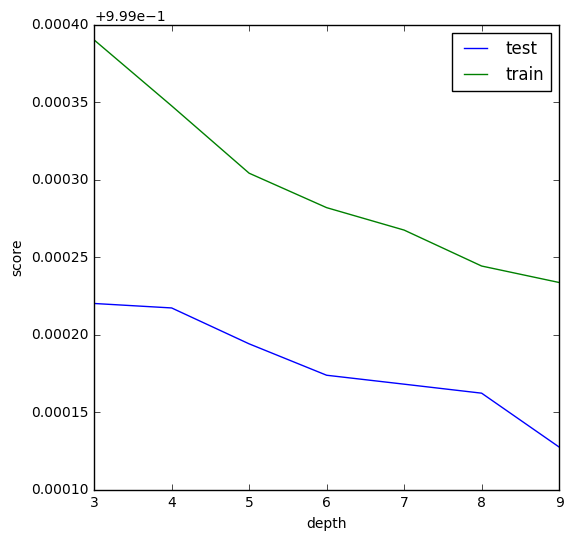

In [53]:
# Plot the f1 score vs. number of neighbors
fig = plt.figure(figsize=(6, 6))
plt.plot(depth,score_test,label='test')
plt.plot(depth,score_train,label='train')
plt.xlabel("neighbors")
plt.ylabel("score")
plt.legend()
plt.show()

Note that I think for this classifier a "good" score is lower.  So, the best number of neighbors is >~9.

In [61]:
# Bagging study
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(n_neighbors=9), max_samples=0.5, max_features=1.0, n_jobs=-1, random_state=42)
bagging.fit(XStrain, ytrain)
ypredBagKNN = bagging.predict(XStest)
                           
print(classification_report(ytest, ypredBagKNN, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.97      0.74      0.84      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



In [55]:
# Bagging with RF
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2), max_samples=0.5, max_features=1.0, n_jobs=-1, random_state=42)
bagging.fit(XStrain, ytrain)
ypredBag = bagging.predict(XStest)
                           
print(classification_report(ytest, ypredBag, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.96      0.72      0.82      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



In [59]:
# Bagging with SVM
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(SVC(), max_samples=0.5, max_features=1.0, n_jobs=-1, random_state=42)
bagging.fit(XStrain, ytrain)
ypredBag = bagging.predict(XStest)
                           
print(classification_report(ytest, ypredBag, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.96      0.79      0.87      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



Is the bagging version any different for the same random state?

In [60]:
from sklearn.svm import SVC
svm = SVC(random_state=42)
svm.fit(XStrain, ytrain)

ypredSVM2 = svm.predict(XStest)
print(classification_report(ytest, ypredSVM2, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.95      0.81      0.88      1043
      stars       1.00      1.00      1.00    172347

avg / total       1.00      1.00      1.00    173390



----

OK, SVM alone gets highest completeness and bagging with KNN gets highest efficiency.  Do CV for both to classify all and look at the results.

In [64]:
clf = SVC(random_state=42)
N=5
ypredCVSVM = cross_val_predict(clf, XS, y, cv=N)

print(classification_report(y, ypredCVSVM, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.91      0.82      0.86      4193
      stars       1.00      1.00      1.00    689365

avg / total       1.00      1.00      1.00    693558



In [65]:
clf = BaggingClassifier(KNeighborsClassifier(n_neighbors=7), max_samples=0.5, max_features=1.0, n_jobs=-1, random_state=42)
N=5
ypredCVbagKNN = cross_val_predict(clf, XS, y, cv=N)

print(classification_report(y, ypredCVbagKNN, target_names=['QSOs', 'stars']))

             precision    recall  f1-score   support

       QSOs       0.90      0.75      0.82      4193
      stars       1.00      1.00      1.00    689365

avg / total       1.00      1.00      1.00    693558



In [66]:
data['ypredSVM'] = ypredCVSVM
data['ypredBAGKNN'] = ypredCVbagKNN

In [67]:
qq = ((data['labels']==0) & (data['ypredSVM']==0))
ss = ((data['labels']==1) & (data['ypredSVM']==1))
qs = ((data['labels']==0) & (data['ypredSVM']==1))
sq = ((data['labels']==1) & (data['ypredSVM']==0))
dataqq = data[qq]
datass = data[ss]
dataqs = data[qs]
datasq = data[sq]

print len(dataqq), "quasars selected as quasars"
print len(dataqs), "quasars selected as stars"
print len(datasq), "stars selected as quasars"

3452 quasars selected as quasars
741 quasars selected as stars
338 stars selected as quasars


In [68]:
qq2 = ((data['labels']==0) & (data['ypredBAGKNN']==0))
ss2 = ((data['labels']==1) & (data['ypredBAGKNN']==1))
qs2 = ((data['labels']==0) & (data['ypredBAGKNN']==1))
sq2 = ((data['labels']==1) & (data['ypredBAGKNN']==0))
dataqq2 = data[qq2]
datass2 = data[ss2]
dataqs2 = data[qs2]
datasq2 = data[sq2]

print len(dataqq2), "quasars selected as quasars"
print len(dataqs2), "quasars selected as stars"
print len(datasq2), "stars selected as quasars"

3153 quasars selected as quasars
1040 quasars selected as stars
343 stars selected as quasars


In [71]:
data.write('GTR-ADM-QSO-ir-testhighz_findbw_lup_2016_starclean_class2.fits', format='fits')

Don't forget that many of the "stars" are quasars with $\lesssim3.5$.
The bagged KNN looks to be pretty clean of stars even though the contamination rate
quoted above is high.  See the redshift histograms below.

Similarly, most of the failed quasars are at $z\gtrsim3$, which isn't all that surprising.

This is about as good as the KDE results (at least for self classification), which got 78% completeness with 97% efficiency (where some of those stars classified as quasars are also likely $z\sim3.5$).  The combination of these suggests that the candidate list that John is using should has 3% or less contamination.  We can check that by also testing the photo-z's.

Make a few plots illustrating that not all of the contamination is from stars (but is instead from $z\lesssim3.5$).

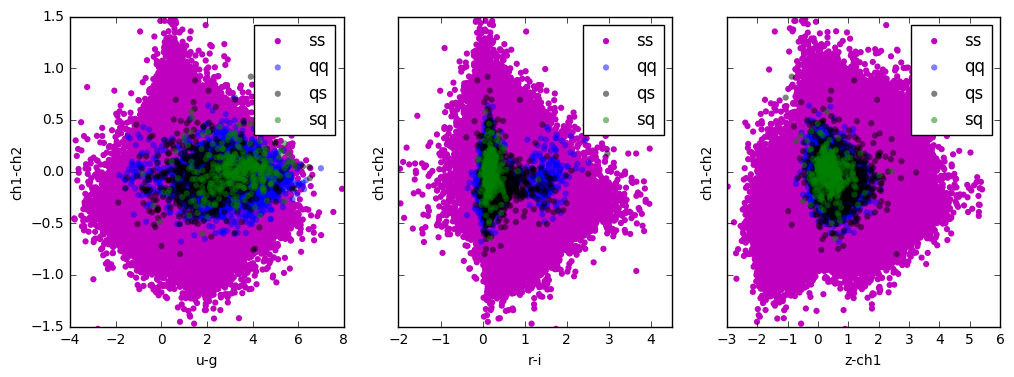

In [72]:
fig = plt.figure(figsize=(12, 4))
#fig.subplots_adjust(vspace=0.05)
ax1 = fig.add_subplot(131)
plt.scatter(datass['ug'],datass['s1s2'],label='ss',edgecolor='None',color='m')
plt.scatter(dataqq['ug'],dataqq['s1s2'],label='qq',edgecolor='None',color='b',alpha=0.5)
plt.scatter(dataqs['ug'],dataqs['s1s2'],label='qs',edgecolor='None',color='k',alpha=0.5)
plt.scatter(datasq['ug'],datasq['s1s2'],label='sq',edgecolor='None',color='g',alpha=0.5)
plt.legend(scatterpoints=1)
plt.xlim([-4,8])
plt.ylim([-1.5,1.5])
plt.xlabel('u-g')
plt.ylabel('ch1-ch2')

ax2 = fig.add_subplot(132)
ax2.yaxis.set_major_formatter(plt.NullFormatter())
plt.scatter(datass2['ri'],datass2['s1s2'],label='ss',edgecolor='None',color='m')
plt.scatter(dataqq2['ri'],dataqq2['s1s2'],label='qq',edgecolor='None',color='b',alpha=0.5)
plt.scatter(dataqs2['ri'],dataqs2['s1s2'],label='qs',edgecolor='None',color='k',alpha=0.5)
plt.scatter(datasq2['ri'],datasq2['s1s2'],label='sq',edgecolor='None',color='g',alpha=0.5)
plt.legend(scatterpoints=1)
plt.xlim([-2,4.5])
plt.ylim([-1.5,1.5])
plt.xlabel('r-i')
plt.ylabel('ch1-ch2')

ax3 = fig.add_subplot(133)
ax3.yaxis.set_major_formatter(plt.NullFormatter())
plt.scatter(datass2['zs1'],datass2['s1s2'],label='ss',edgecolor='None',color='m')
plt.scatter(dataqq2['zs1'],dataqq2['s1s2'],label='qq',edgecolor='None',color='b',alpha=0.5)
plt.scatter(dataqs2['zs1'],dataqs2['s1s2'],label='qs',edgecolor='None',color='k',alpha=0.5)
plt.scatter(datasq2['zs1'],datasq2['s1s2'],label='sq',edgecolor='None',color='g',alpha=0.5)
plt.legend(scatterpoints=1)
plt.xlim([-3,6])
plt.ylim([-1.5,1.5])
plt.xlabel('z-ch1')
plt.ylabel('ch1-ch2')

plt.show()

These are more revealing as contours or density plots (which I examined in TOPCAT), but I'm going to leave them as they are for now.

Histogram of SVM selection.

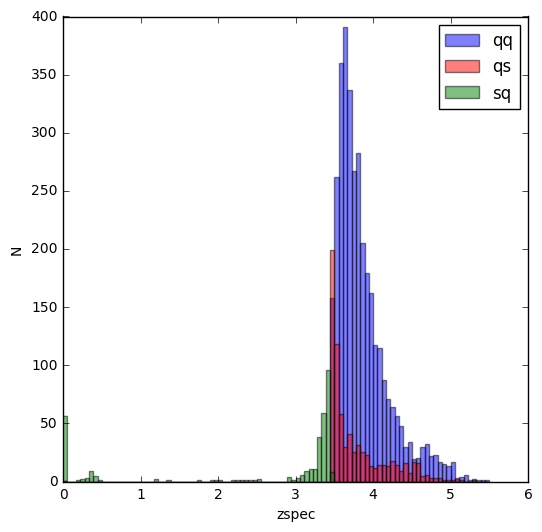

In [69]:
fig = plt.figure(figsize=(6, 6))
bins=np.linspace(0,5.5,100)
plt.hist(dataqq['zspec'],bins=bins,label='qq',color='b',alpha=0.5)
plt.hist(dataqs['zspec'],bins=bins,label='qs',color='r',alpha=0.5)
plt.hist(datasq['zspec'],bins=bins,label='sq',color='g',alpha=0.5)
#plt.xlim([-4,8])
#plt.ylim([-1.5,1.5])
plt.legend()
plt.xlabel('zspec')
plt.ylabel('N')

Star contam appears to be lower than for RF in SpIESHighzCandidateSelection

Histogram of Bagging selection.

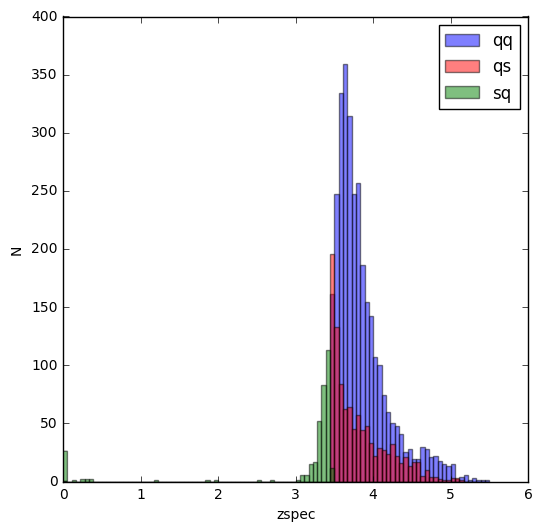

In [70]:
fig = plt.figure(figsize=(6, 6))
bins=np.linspace(0,5.5,100)
plt.hist(dataqq2['zspec'],bins=bins,label='qq',color='b',alpha=0.5)
plt.hist(dataqs2['zspec'],bins=bins,label='qs',color='r',alpha=0.5)
plt.hist(datasq2['zspec'],bins=bins,label='sq',color='g',alpha=0.5)
#plt.xlim([-4,8])
#plt.ylim([-1.5,1.5])
plt.legend()
plt.xlabel('zspec')
plt.ylabel('N')

Star contam here is the lowest of all.  So, try to implement this in `SpIESHighzQuasars2`.  But we'll find that that causes trouble given how slow it is.